# Task 2 – Data Loading and Augmentation

We take the data from task 1, using the CustomDataset class we can load the data into the model, using torch DataLoader.
The data augmentation consists of a random horizontal flip, a random rotation up to 20 degrees and an affine transformation to make the model more robust for random patient oerientation. The randomaffine transform makes the model more robust. A scalejitter transformation makes the model more robust to images taken at different scales. Gaussian blur and noise make the model more robust to imperfect data.

In [38]:
import numpy as np
import glob
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms

In [39]:
class CustomDataset(Dataset):
    def __init__(self, img_size, class_names, path=None, transformations=None, num_per_class: int = -1):
        self.img_size = img_size
        self.path = path
        self.num_per_class = num_per_class
        self.class_names = class_names
        self.transforms = transformations
        self.data = []
        self.labels = []

        if path:
            self.readImages()

        # These are the transforms that are applied to the testing and validation data
        self.standard_transforms = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(img_size)])

    # This functions reads out the images from the data folders, it assigns them a label
    def readImages(self):
        for id, class_name in self.class_names.items():
            print(f'Loading images from class: {id} : {class_name}')
            img_path = glob.glob(f'{self.path}{class_name}/*.jpg')
            if self.num_per_class > 0:
                img_path = img_path[:self.num_per_class]
            self.labels.extend([id] * len(img_path))
            for filename in img_path:
                img = Image.open(filename).convert('L')
                img = img.resize(self.img_size)
                self.data.append(img)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transforms:
            img = self.transforms(img)
        else:
            img = self.standard_transforms(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label

In [40]:
# Data augmentation transformation, some commented out due to import errors
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    # transforms.v2.ScaleJitter(target_scale=img_size, scale_range=(0.9, 1.1)),
    transforms.RandomAutocontrast(p=0.25),
    # transforms.GaussianBlur(kernel_size=3, sigma=(0,2.0)),
    # transforms.GaussianNoise(kernel_size=3, std=0.1)
])

# Paths to the data
train_path = "./data/training/"
test_path = "./data/testing/"
validation_path = "./data/validation/"

# Size of the images in the model (should be optimized)
img_size=(256,256)


class_names = [name[len(train_path):] for name in glob.glob(f'{train_path}*')]
class_names = dict(zip(range(len(class_names)), class_names))

train_dataset = CustomDataset(img_size=img_size, path=train_path, class_names=class_names, transformations=train_transform)
test_dataset = CustomDataset(img_size=img_size, path=test_path, class_names=class_names)
validation_dataset = CustomDataset(img_size=img_size, path=validation_path, class_names=class_names)

# We could add batches to the DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, shuffle=True)

Loading images from class: 0 : normal
Loading images from class: 1 : pneumonia
Loading images from class: 0 : normal
Loading images from class: 1 : pneumonia
Loading images from class: 0 : normal
Loading images from class: 1 : pneumonia


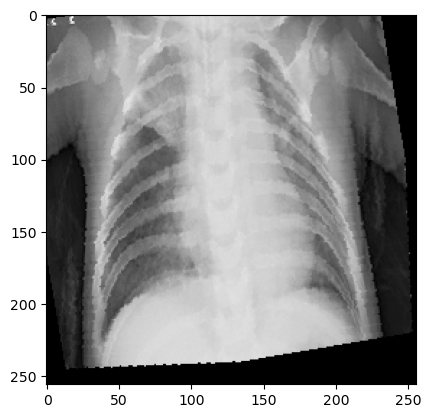

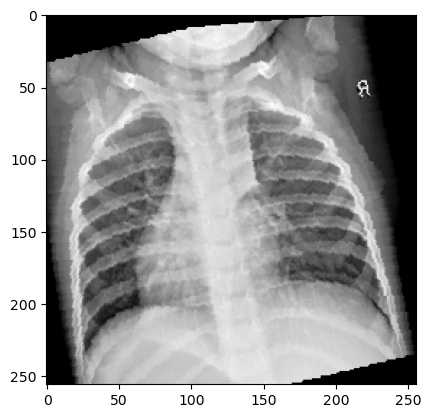

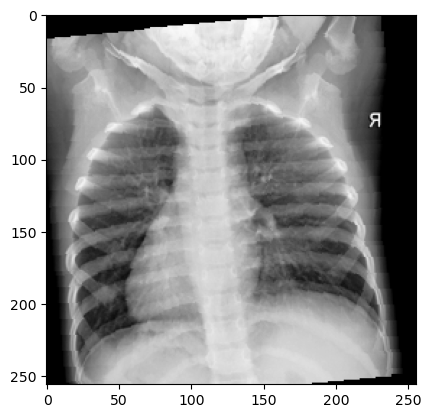

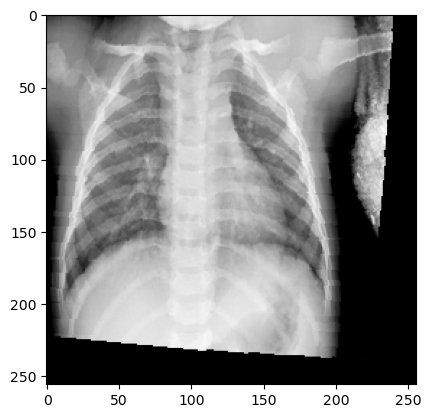

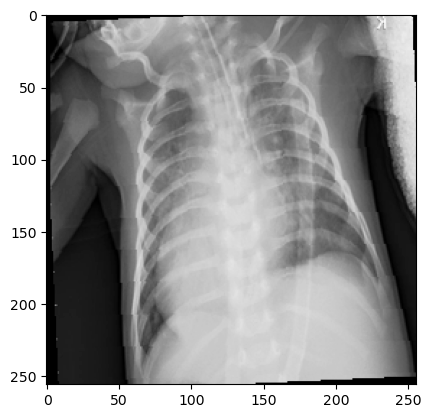

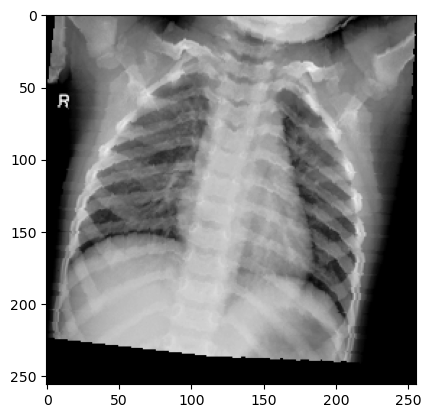

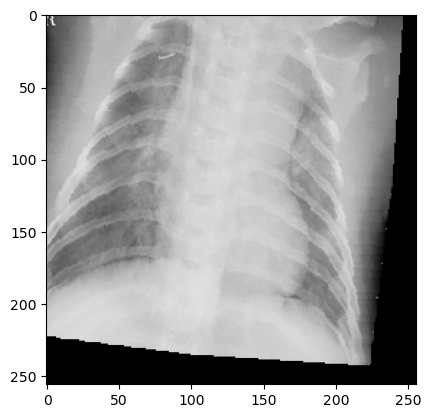

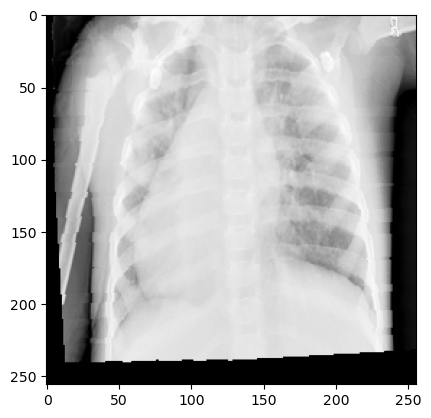

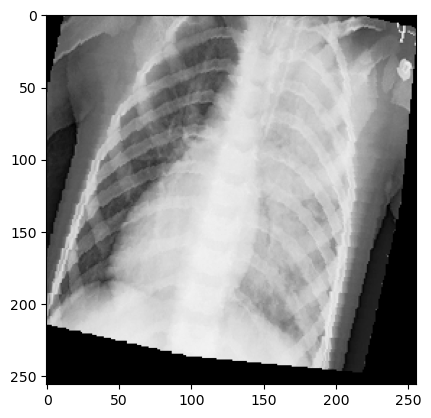

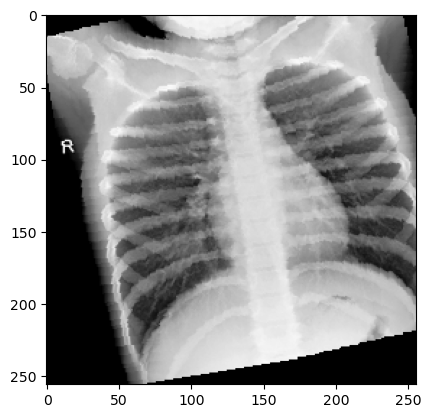

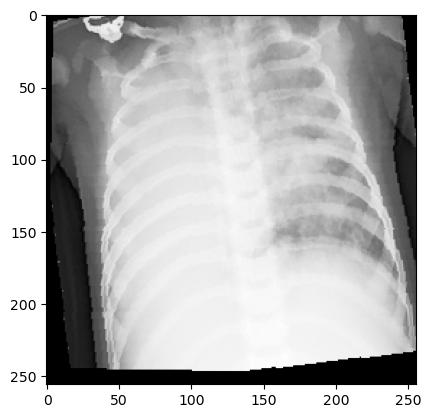

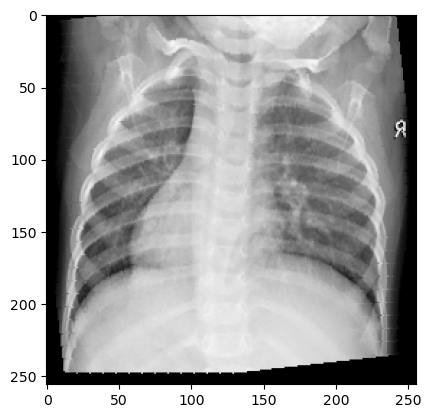

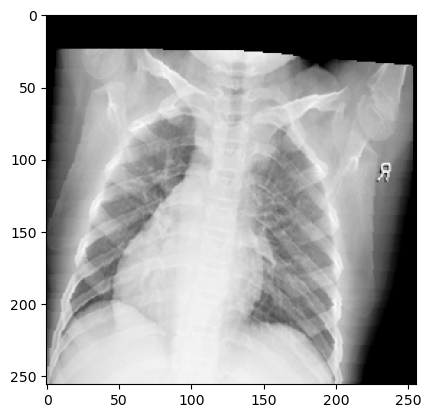

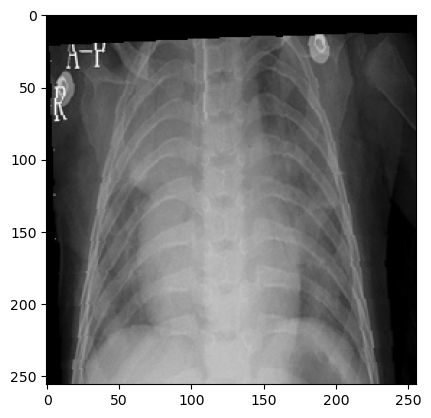

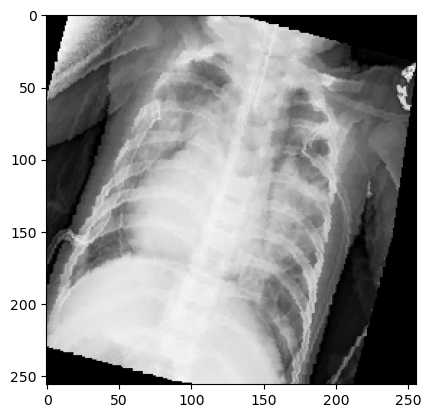

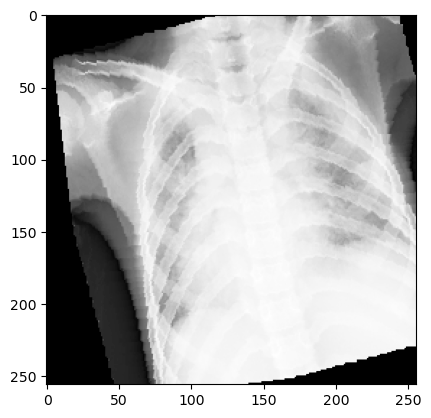

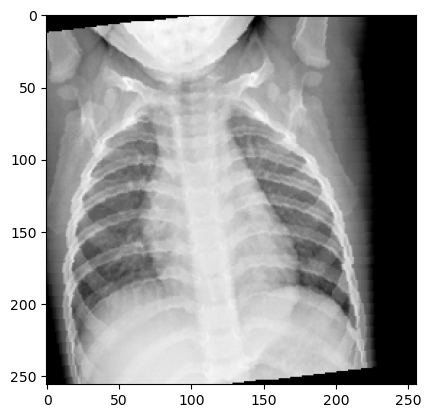

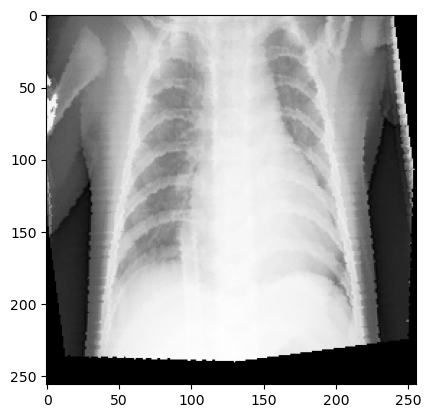

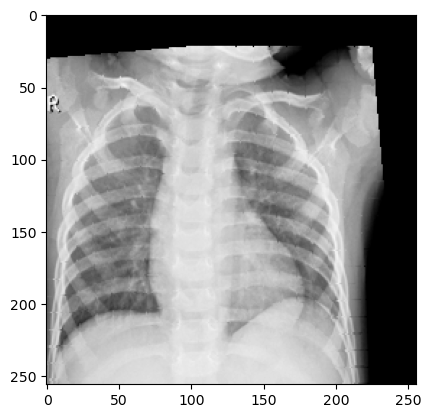

In [41]:
import matplotlib.pyplot as plt
i = 0

for images,labels in train_dataloader:
    if 50 < i < 70:
        plt.imshow(torch.reshape(images[0], [256, 256, 1]), cmap='Greys_r')
        plt.show()
    i += 1